**Setup of the Jupyter Notebook Environment**

In [1]:
# importing libraries
import os
import time
import glob
import numpy as np
import pandas as pd
import cv2
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
# initiating deterministic seed
seed_value = 1234
np.random.seed(seed_value) # setting numpy seed

In [3]:
# setting cpu or gpu enabled device
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu').type

# initiating deterministic GPU and CPU seed
torch.manual_seed(seed_value) # set pytorch seed

# log type of device enabled

print('[LOG] notebook with {} computation enabled'.format(str(device)))

[LOG] notebook with cuda computation enabled


In [4]:
!nvidia-smi

Wed Jan 28 11:32:21 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
# mounting Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
# checking whether directory exists
print(os.listdir('/content/drive/MyDrive/Colab Notebooks/SalmonScan'))

['Raw', 'Augmented']


**Preparing the dataset**

In [7]:
# listing all images files
main_dir = '/content/drive/MyDrive/Colab Notebooks/SalmonScan'

image_paths = glob.glob(os.path.join(main_dir, '**', '*.jpg'), recursive=True)
image_paths += glob.glob(os.path.join(main_dir, '**', '*.png'), recursive=True)

print(f"Found {len(image_paths)} images.")
print("Sample paths:", image_paths[:3])  # printing first 3 paths as a sample

Found 1322 images.
Sample paths: ['/content/drive/MyDrive/Colab Notebooks/SalmonScan/Raw/FreshFish/a_salmon_fresh_16.png', '/content/drive/MyDrive/Colab Notebooks/SalmonScan/Raw/FreshFish/a_salmon_fresh_01.png', '/content/drive/MyDrive/Colab Notebooks/SalmonScan/Raw/FreshFish/a_salmon_fresh_14.png']


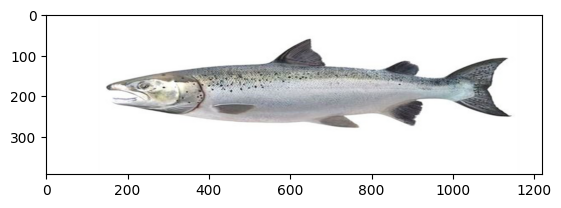

In [8]:
# loading the first image from the list
img = mpimg.imread(image_paths[0])
plt.imshow(img)

In [9]:
# creating a list of tuples: (image_path, label)
labeled_data = []
for path in image_paths:
    label = os.path.basename(os.path.dirname(path))
    labeled_data.append((path, label))

for path, label in labeled_data[:5]:
    print(f"Image: {path}, Label: {label}") # printing the first 5 entries to verify

Image: /content/drive/MyDrive/Colab Notebooks/SalmonScan/Raw/FreshFish/a_salmon_fresh_16.png, Label: FreshFish
Image: /content/drive/MyDrive/Colab Notebooks/SalmonScan/Raw/FreshFish/a_salmon_fresh_01.png, Label: FreshFish
Image: /content/drive/MyDrive/Colab Notebooks/SalmonScan/Raw/FreshFish/a_salmon_fresh_14.png, Label: FreshFish
Image: /content/drive/MyDrive/Colab Notebooks/SalmonScan/Raw/FreshFish/a_salmon_fresh_04.png, Label: FreshFish
Image: /content/drive/MyDrive/Colab Notebooks/SalmonScan/Raw/FreshFish/a_salmon_fresh_06.png, Label: FreshFish


In [10]:
# transforming the list into a dataframe
df = pd.DataFrame(labeled_data, columns=['path', 'label'])

print(df.head())

                                                path      label
0  /content/drive/MyDrive/Colab Notebooks/SalmonS...  FreshFish
1  /content/drive/MyDrive/Colab Notebooks/SalmonS...  FreshFish
2  /content/drive/MyDrive/Colab Notebooks/SalmonS...  FreshFish
3  /content/drive/MyDrive/Colab Notebooks/SalmonS...  FreshFish
4  /content/drive/MyDrive/Colab Notebooks/SalmonS...  FreshFish


In [11]:
# initialising lists to store images and labels
images = []
labels = []

for index, row in df.iterrows():
    image = cv2.imread(row['path'])
    image = cv2.resize(image, (600, 250))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(image)
    labels.append(row['label'])

# converting to NumPy arrays
images = np.array(images)
labels = np.array(labels)

images = images.astype('float32') / 255.0

print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

Images shape: (1322, 250, 600, 3)
Labels shape: (1322,)


In [12]:
# encoding labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

print("Encoded labels:", encoded_labels[:5])

Encoded labels: [0 0 0 0 0]


In [13]:
# converting images and labels to PyTorch tensors
images_tensor = torch.from_numpy(images).float().permute(0, 3, 1, 2)
labels_tensor = torch.from_numpy(encoded_labels).float().view(-1, 1)

In [14]:
# creating custom dataset
class SalmonDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

In [15]:
# splitting into training and validation datasets
train_images, test_images, train_labels, test_labels = train_test_split(
    images_tensor, labels_tensor, test_size=0.3, random_state=42
)

In [16]:
# creating dataloaders
train_dataset = SalmonDataset(train_images, train_labels)
test_dataset = SalmonDataset(test_images, test_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [17]:
len(train_loader)

58

In [18]:
len(test_loader)

25

In [19]:
# defining a function for plot for inspecting samples
def plot_images(images, n_rows=1):
    fig, axs = plt.subplots(n_rows, images.size(0) // n_rows)
    for ax, img in zip(axs.flat, images):
        ax.matshow(img[0].cpu().numpy(), cmap=plt.cm.Greys)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    plt.tight_layout(w_pad=0)

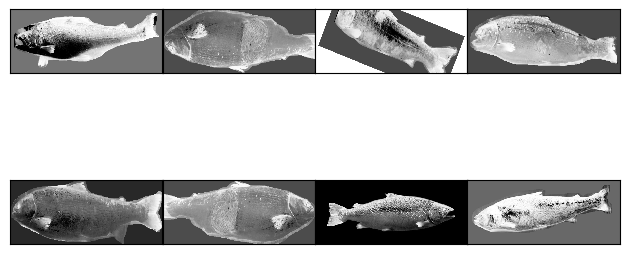

In [20]:
# inspecting sample images
images, labels = next(iter(train_loader))
plot_images(images[:8], n_rows=2)

**Defining the CNN architecture**

In [21]:
# architecture of the CNN
class SalmonNet(nn.Module):
    def __init__(self):
        super(SalmonNet, self).__init__()

        self.convolutional_layer = nn.Sequential(

            # convolutional layer 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),

            # max pooling layer 1
            nn.MaxPool2d(kernel_size=2, stride=2),

            # convolutional layer 2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),

            # max pooling layer 2
            nn.MaxPool2d(kernel_size=2, stride=2),

            # convolutional layer 3
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),

            # max pooling layer 3
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.linear_layer = nn.Sequential(
            nn.Linear(in_features=128 * 31 * 75, out_features=128),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=128, out_features=1)
        )

    def forward(self, x, verbose=False):
        x = self.convolutional_layer(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layer(x)
        return x

In [22]:
# checking the shape of the output of the CNN
def test_Net_shapes():
    net = SalmonNet()
    net.to(device)

    with torch.no_grad():
        images, labels = next(iter(train_loader))
        images = images.to(device)
        print('Shape of the input tensor:', images.shape)

        y = net(images, verbose=True)
        print('Shape of the output tensor:', y.shape)

    print('Success')

test_Net_shapes()

Shape of the input tensor: torch.Size([16, 3, 250, 600])
Shape of the output tensor: torch.Size([16, 1])
Success


In [23]:
# instantiating a network model to be trained
net = SalmonNet()
net = net.to(device) # as specified in code cell 3

**Training the CNN model**

In [24]:
# a function for computing metrics on the val dataset
def compute_metrics(net, test_loader):
    net.eval()
    true_labels = []
    predicted_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)

    return accuracy, precision, recall, f1

In [25]:
# defining the loss function
pos_weight = torch.tensor([35/65]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# defining the optimiser
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001, weight_decay=1e-5)

# init collection of training epoch losses
train_losses = []

# setting the model in training mode
net.train()

SalmonNet(
  (convolutional_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layer): Sequential(
    (0): Linear(in_features=297600, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [26]:
# creating variables for training loop with 10 epochs
best_accuracy = 0.0
patience = 3
no_improvement = 0
epochs = 10

In [27]:
# implementing the training loop
for epoch in range(epochs):

    # initiating the time
    time0 = time.time()

    # initiating collection of mini-batch losses
    running_loss=[]

    # iterating over all-mini batches
    for batch_idx, data in enumerate(train_loader,0):

        # pushing mini-batch data to computation device
        inputs,target = data
        inputs,target = inputs.to(device), target.to(device)

        # running forward pass through the network
        outputs = net(inputs, verbose=True)

        # resetting graph gradients
        optimizer.zero_grad()

        # determining classification loss
        loss = criterion(outputs,target)

        # running backward pass to update the weights
        loss.backward()

        # updating network paramaters
        optimizer.step()

        # collecting mini-batch reconstruction loss
        running_loss.append(loss.item())

    # determining mean min-batch loss of epoch
    train_loss = np.mean(running_loss)
    train_losses.append(train_loss)

    # calculating validation metrics
    train_accuracy, train_precision, train_recall, train_f1 = compute_metrics(net, test_loader)

    # saving the best model
    if train_accuracy > best_accuracy:
        best_accuracy = train_accuracy
        model_path = os.path.join('/content/drive/MyDrive/Colab Notebooks/SalmonScan', 'best_salmon_model.pth')
        torch.save(net.state_dict(), model_path)
        print(f"New best model saved with accuracy: {train_accuracy:.3f}")
        no_improvement = 0
    else:
        no_improvement += 1

    # printing epoch loss and metrics
    if epoch % 1 == 0:
        print(
            f"epoch:{epoch+1}",
            "\ttrain_loss:",
            round(train_loss, 3),
            "\taccuracy:",
            round(train_accuracy, 3),
            "\tprecision:",
            round(train_precision, 3),
            "\trecall:",
            round(train_recall, 3),
            "\tF1:",
            round(train_f1, 3),
            "\tUsed_time:",
            round((time.time() - time0) / 60, 3)
        )

    # early stopping check
    if no_improvement >= patience:
        print(f'Early stopping at epoch {epoch}')
        break

New best model saved with accuracy: 0.919
epoch:1 	train_loss: 0.662 	accuracy: 0.919 	precision: 0.918 	recall: 0.955 	F1: 0.936 	Used_time: 0.15
epoch:2 	train_loss: 0.202 	accuracy: 0.914 	precision: 0.934 	recall: 0.927 	F1: 0.93 	Used_time: 0.126
New best model saved with accuracy: 0.927
epoch:3 	train_loss: 0.142 	accuracy: 0.927 	precision: 0.919 	recall: 0.967 	F1: 0.942 	Used_time: 0.141
epoch:4 	train_loss: 0.116 	accuracy: 0.904 	precision: 0.929 	recall: 0.914 	F1: 0.922 	Used_time: 0.125
New best model saved with accuracy: 0.940
epoch:5 	train_loss: 0.059 	accuracy: 0.94 	precision: 0.947 	recall: 0.955 	F1: 0.951 	Used_time: 0.175
New best model saved with accuracy: 0.947
epoch:6 	train_loss: 0.041 	accuracy: 0.947 	precision: 0.963 	recall: 0.951 	F1: 0.957 	Used_time: 0.14
epoch:7 	train_loss: 0.048 	accuracy: 0.935 	precision: 0.933 	recall: 0.963 	F1: 0.948 	Used_time: 0.127
epoch:8 	train_loss: 0.021 	accuracy: 0.94 	precision: 0.937 	recall: 0.967 	F1: 0.952 	Used_t

<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:13: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-1509641066.py:13: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel("[Classification Error $\mathcal{L}^{NLL}$]", fontsize=10)


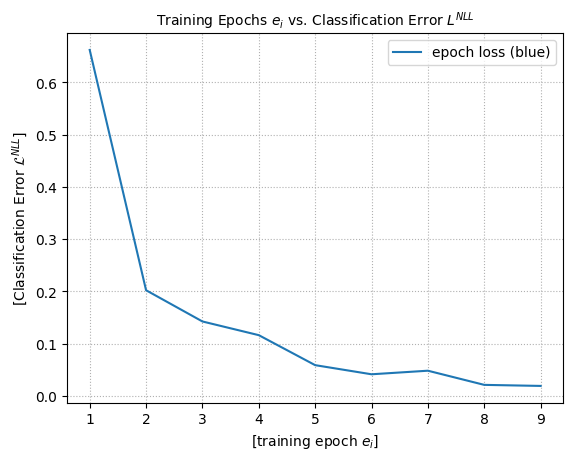

In [28]:
# preparing train_loss plot
fig = plt.figure()
ax = fig.add_subplot(111)

# adding grid
ax.grid(linestyle='dotted')

# plotting the training epochs vs. the epochs' classification error
ax.plot(np.array(range(1, len(train_losses)+1)), train_losses, label='epoch loss (blue)')

# adding axis legends
ax.set_xlabel("[training epoch $e_i$]", fontsize=10)
ax.set_ylabel("[Classification Error $\mathcal{L}^{NLL}$]", fontsize=10)

# setting plot legend
plt.legend(loc="upper right", numpoints=1, fancybox=True)

# adding plot title
plt.title('Training Epochs $e_i$ vs. Classification Error $L^{NLL}$', fontsize=10);

**Evaluating the CNN model**

In [29]:
# loading the best model
model = SalmonNet()
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

<All keys matched successfully>

In [30]:
# setting them model in evaluation mode
model.eval

<bound method Module.eval of SalmonNet(
  (convolutional_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layer): Sequential(
    (0): Linear(in_features=297600, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)>

Predicted Probability: 0.9998
Predicted Label: 1
Predicted Class: InfectedFish


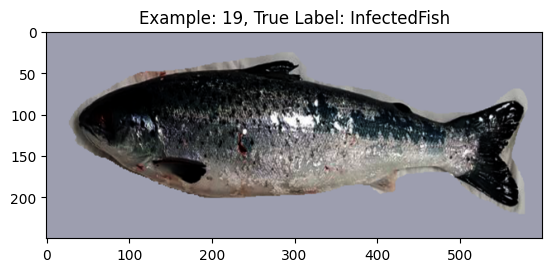

In [31]:
# setting a random image ID for inspecting sample predicitons
image_id = 19

# retrieving the image and label using the image ID
eval_image, eval_label = test_dataset[image_id]

# converting eval_label to an integer
eval_label = int(eval_label.item()) if hasattr(eval_label, 'item') else int(eval_label)

# defining the classes for your dataset
classes = ["FreshFish", "InfectedFish"]

# setting image plot title
plt.title(f'Example: {image_id}, True Label: {classes[eval_label]}')

# converting the image tensor to a PIL image for display
trans = torchvision.transforms.ToPILImage()

# plotting the image
plt.imshow(trans(eval_image))

# predicting the label of the image
eval_image_tensor = eval_image.unsqueeze(0).cpu()
with torch.no_grad():
    output = model(eval_image_tensor)
    predicted_prob = torch.sigmoid(output).item()
    predicted_label = 1 if predicted_prob > 0.5 else 0

print(f'Predicted Probability: {predicted_prob:.4f}')
print(f'Predicted Label: {predicted_label}')
print(f'Predicted Class: {classes[predicted_label]}')


In [32]:
# storing the predicted classes on the test dataset
true_labels = []
predictions = []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        true_labels.extend(labels.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())

In [33]:
# calculating metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)

# printing the results
print(f'Accuracy: {accuracy:.3f}')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1-Score: {f1:.3f}')

Accuracy: 0.922
Precision: 0.915
Recall: 0.963
F1-Score: 0.938


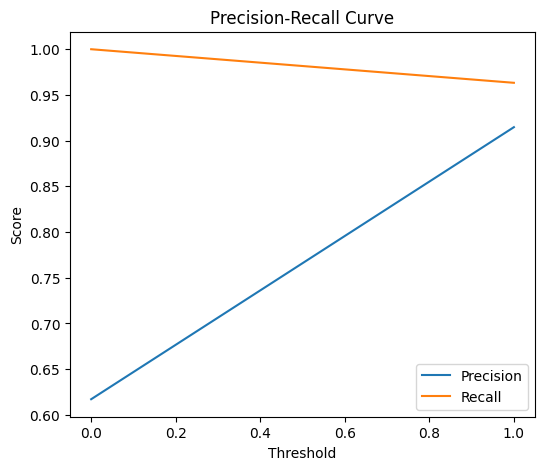

In [34]:
# Assuming you have true_labels and predicted_probs from your test set
precision, recall, thresholds = precision_recall_curve(true_labels, predictions)

# Plot precision and recall vs. threshold
plt.figure(figsize=(6, 5))
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.title("Precision-Recall Curve")
plt.show()

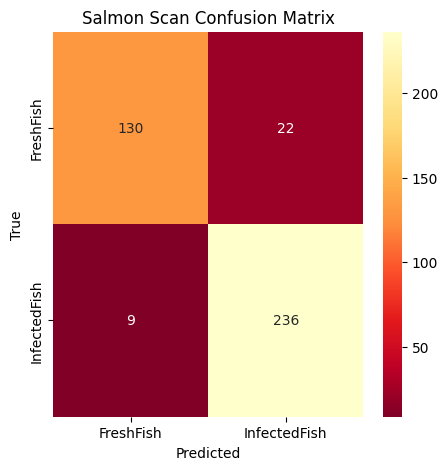

In [35]:
# inspecting the confusion matrix
cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd_r',
            xticklabels=["FreshFish", "InfectedFish"],
            yticklabels=["FreshFish", "InfectedFish"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Salmon Scan Confusion Matrix')
plt.show()